# Argusa Challenge day 18/10/2023
## Import packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

## Read Data

In [169]:
o20 = pd.read_csv('./ArgusaChallenge2023/orders_2020.csv')
o21 = pd.read_csv('./ArgusaChallenge2023/orders_2021.csv')
o22 = pd.read_csv('./ArgusaChallenge2023/orders_2022.csv')
o23 = pd.read_csv('./ArgusaChallenge2023/orders_2023.csv')
clients = pd.read_csv('./ArgusaChallenge2023/clients.csv')
ratings = pd.read_csv('./ArgusaChallenge2023/ratings.csv')
returns = pd.read_csv('./ArgusaChallenge2023/returns.csv')

products_original=pd.read_csv('./ArgusaChallenge2023/products.csv')
total_revenues = 46449091 #Information from the jury to double check

## Join data and do a conditional merge with orders and products

In [182]:
orders = pd.concat([o20, o21, o22, o23])

# Now we need to do a conditional merge of the orders and the products. Condition on the date
orders_merged = pd.DataFrame()
products=products_original.rename(columns={"id": "product_id"})
returned=np.zeros(len(products.index))
sold=np.zeros(len(products.index))
# Loop over product row (which means id and date range). 
# The order table subset that has that id and the date in the range, 
# will be joined with the row
for index, row in products.iterrows():
    df_to_merge = orders[(orders.order_date >= row.start_date) & (orders.order_date <= row.end_date) & (orders.product_id == row.product_id)]
    products_to_merge = products[(products.start_date == row.start_date) & (products.end_date == row.end_date) & (products.product_id == row.product_id)]
    df_to_merge = df_to_merge.merge(products_to_merge, on='product_id', validate='many_to_one')
    orders_merged = pd.concat([orders_merged, df_to_merge])

    # Counting number of sold and returned items
    sold[index]=len(df_to_merge.index)
    returned[index]=len(df_to_merge.order_id[np.in1d(df_to_merge.order_id, returns.order_id)])

products['returned']=returned; products['sold']=sold
orders_merged.sort_values('order_date', inplace=True, ignore_index=True)

False

## Add returned items

In [185]:
# Adding also the returned items
orders_w_returns = pd.merge(orders_merged, returns, on=['order_id', 'product_id'], how='left')
orders = orders_w_returns

# Filter rows where 'return_date' is null
orders_no_returns = orders[orders['return_date'].isnull()]
orders_no_returns.reset_index(drop=True, inplace=True)

In [186]:
# Calculating some quantities on the products
products['sales'] = products.sale_price*products.sold
products['profit'] = (products.sale_price-products.base_price)*products.sold
products['profit_margin'] = (products.sale_price-products.base_price)/products.sale_price

products['revenue'] = products.sale_price*(products.sold-products.returned)
products['net_profit'] = (products.sale_price-products['base_price'])*(products.sold-products.returned)
products['profit_ratio'] = products['net_profit']/products['revenue']

In [187]:
print(f'{products.revenue.sum()}, {total_revenues}, {products.revenue.sum()/total_revenues}')

39342790.29, 46449091, 0.8470088314537737


## Q1: Most profitable month and year - Correct with Argusa answers

In [112]:
index_datetime = pd.to_datetime(orders_merged['order_date'],infer_datetime_format=True)
orders_datetime=orders_merged.copy()
orders_datetime.index=index_datetime
orders_datetime['profit'] = orders_datetime['sale_price']-orders_datetime['base_price']
orders_m = orders_datetime.resample('M')[['sale_price', 'profit']].sum()

In [113]:
month_most_profitable = orders_m['profit'].idxmax()
print(f'Month most profitable: {month_most_profitable:%m-%Y}')
print(f'Profit: {1e-3*orders_m["profit"][month_most_profitable]:.3f} k')
print(f'Sales: {1e-3*orders_m["sale_price"][month_most_profitable]:.3f} k')      

Month most profitable: 12-2021
Profit: 244.177 k
Sales: 2595.286 k


Text(0, 0.5, 'Sales [k$]')

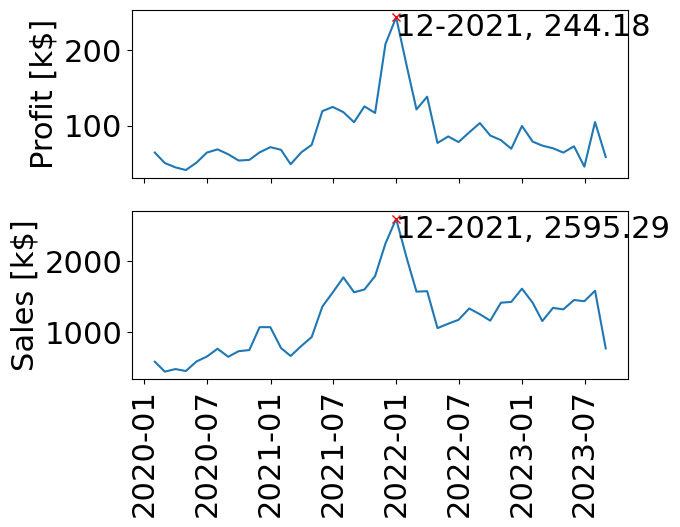

In [129]:
f,ax = plt.subplots(2,1)
ax[0].plot(1e-3*orders_m['profit']); 
plt.xticks(rotation='vertical')
ax[0].plot(month_most_profitable, 1e-3*orders_m['profit'][month_most_profitable], 'rx')
ax[0].text(month_most_profitable, 0.9e-3*orders_m['profit'][month_most_profitable], f'{month_most_profitable:%m-%Y}, {1e-3*orders_m["profit"][month_most_profitable]:.2f}')
ax[0].set_ylabel('Profit [k$]')
ax[0].set_xticklabels([])
ax[1].plot(1e-3*orders_m['sale_price']);
ax[1].plot(month_most_profitable, 1e-3*orders_m['sale_price'][month_most_profitable], 'rx')
ax[1].text(month_most_profitable, 0.9e-3*orders_m['sale_price'][month_most_profitable], f'{month_most_profitable:%m-%Y}, {1e-3*orders_m["sale_price"][month_most_profitable]:.2f}')
ax[1].set_ylabel('Sales [k$]')


## Question 2
Which product(s) have the highest sales, profit ratio and average profit margin and what are those values?

In [119]:
prod_newtable =  products.groupby('name').sum([['sales', 'profit_ratio']])
for quantity in ['sales', 'profit_ratio']:    
    highest = prod_newtable[quantity].idxmax()
    print(f'Product with highest {quantity}: {highest}; Highest {quantity}: {prod_newtable["sales"][highest]:.2f}')

Product with highest sales: LG OLED77C27LA, 4K, OLED, 2022, 77"; Highest sales: 3471464.47
Product with highest profit_ratio: Beaba Lunettes de soleil à la craie pour nouveau-nés; Highest profit_ratio: 98651.42


In [93]:
mean_prof_margin =  products.groupby('name').mean('profit_margin')
highest = mean_prof_margin['profit_margin'].idxmax();
print(f'Product with highest mean_prof_margin: {highest}; Highest mean prof margin: {mean_prof_margin["profit_margin"][highest]:.2f}')


Product with highest mean_prof_margin: Beaba Lunettes de soleil à la craie pour nouveau-nés; Highest mean prof margin: 0.41


In [ ]:
## This is the answer prepared by Aylwin
total_sale = []
ids = o23_new['product_id'].unique()
for id in ids:
   sales = o23_new['price_sold'].loc[o23_new['product_id'] == id]
   total_sale.append(sales.sum())


# plot id tolat sales
fig, ax = plt.subplots()
ax.plot(ids,total_sale,"kx")
ax.set_title('Total sale per id')
ax.set_xlabel('Id')
plt.show()  


# max sales id 22
max_sale_id = ids[np.argmax(total_sale)]


# get product name
product1_name = products['name'].loc[products['id'] == max_sale_id].iloc[0]
# product name is
#Samsung QE85Q60BA, 4K, QLED, 2022, 85

## Question 3 - Our answer was scripted correctly
What fraction (%) of returned products are in each category (use category 1)?

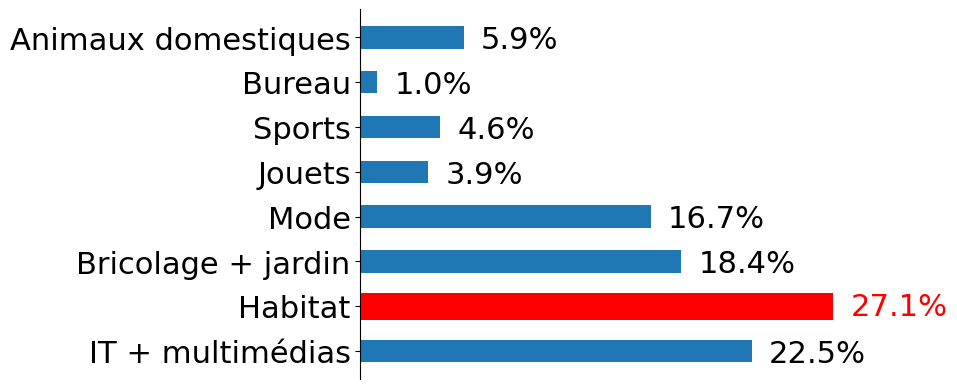

In [94]:
categories = products['category_1'].unique()
returns_id = []
for cat in categories:
     cat_id = products.loc[products['category_1'] == cat]['product_id']
     returns_id.append(returns[returns['product_id'].isin(cat_id)].shape[0])
   

# Sum returns for each cat
fig, ax = plt.subplots()
ax.barh(categories, returns_id/np.sum(returns_id), height=0.5)
ax.barh(categories[1], returns_id[1]/np.sum(returns_id), color='red', height=0.6)
for i in range(np.size(returns_id)):
    if i==1: continue
    ax.text(returns_id[i]/np.sum(returns_id)+0.01, i-0.25, f'{returns_id[i]/np.sum(returns_id)*100:.1f}%')
    
ax.text(returns_id[1]/np.sum(returns_id)+0.01, 0.8, f'{returns_id[1]/np.sum(returns_id)*100:.1f}%', color='red')
#ax.set_yticklabels(categories.iloc)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xlabel('Returned products (%)')
plt.show()

## Question 4 - For some reasons it's wrong (I guess it's because the merge at the beginning is wrong)
Who are the top 3 clients by revenue and what is the revenue?

In [144]:
data=pd.DataFrame.copy(orders_no_returns)
#client_buy = np.array([])
client_net = np.array([])

for cl_id in clients['client_id'].values:
    ind_ord_clients = np.where(data['client_id'].values==cl_id)[0]
    #ind_net_clients = np.where(np.logical_and(data['client_id'].values==cl_id, 
    #                                          pd.isnull(data['return_date']).values))[0]
    #client_buy = np.append(client_buy, np.sum(data['sale_price'][ind_ord_clients].values))
    client_net = np.append(client_net, np.sum(data['sale_price'][ind_ord_clients].values))
    
#clients['buy_total']=client_buy
clients['net_total']=client_net

In [145]:
clients_sorted = clients.sort_values(by='net_total', ascending=False)
# Printing first three clients with ID, name and revenue
for i in [0,1,2]:
    print(clients_sorted.iloc[i]['client_id'],clients_sorted.iloc[i]['last_name'], clients_sorted.iloc[i]['fisrt_name'], clients_sorted.iloc[i]['net_total'])
    
#A4-819583b Delèze François 32148.409999999996
#V0-0674179j Jacot-Guillarmod Jonathan 24848.71
#u0-8614055c Rappaz Jean 24245.170000000002

A4-819583b Delèze François 33004.46000000001
V0-0674179j Jacot-Guillarmod Jonathan 30356.120000000003
t4-7733897B Duroux Sarah 27556.78


Text(0, 0.5, 'Net revenue (k$)')

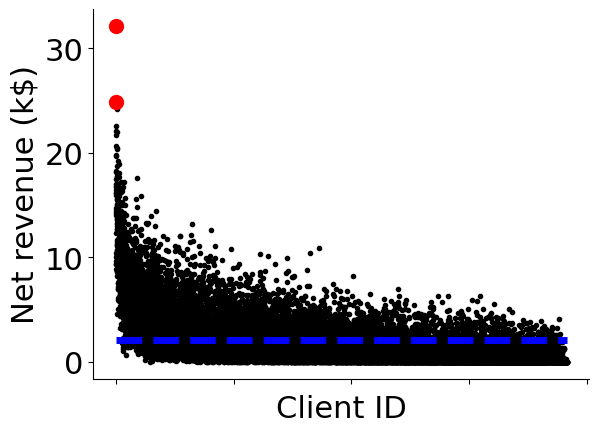

In [93]:
# scatter plot of their revenue
fig, ax =plt.subplots()
ax.plot(clients['net_total']*1e-3, 'k.')
ax.plot(clients_sorted['net_total'][0:2]*1e-3, 'ro', markersize=10)
ax.plot([0,np.size(clients['net_total'])], [np.mean(clients['net_total']*1e-3), np.mean(clients['net_total']*1e-3)], 'b--', linewidth=5)
ax.set_xlabel('Client ID')
ax.xaxis.set_ticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Net revenue (k$)')

## Which client has the most returned products? 

In [ ]:
#### Question 5 ####
####################
n_ret_items = np.array([])
n_buy_items = np.array([])
total_ret=np.zeros(np.size(clients['client_id']))
total_buy =np.zeros(np.size(clients['client_id']))
for year in [2020, 2021, 2022, 2023]:
    if year==2020: data=pd.DataFrame.copy(o20_new)
    elif year==2021: data=pd.DataFrame.copy(o21_new)
    elif year==2022: data=pd.DataFrame.copy(o22_new)
    elif year==2023: data=pd.DataFrame.copy(o23_new)

    client_buy = np.array([])
    client_return = np.array([])

    for ii, cl_id in enumerate(clients['client_id'].values):
        ind_ord_clients = np.where(data['client_id'].values==cl_id)[0]
        n_buy=np.size(ind_ord_clients)
        year_buy = np.append(client_buy, n_buy)
        
        n_ret=0;
        for o_ret in data['order_id'][ind_ord_clients]:
            if o_ret in returns['order_id'].values:
                n_ret+=1
        year_return=np.append(client_return, n_ret)
    print(np.size(total_ret), np.size(year_return))
    total_ret = total_ret+year_return
    total_buy = total_buy+year_buy

In [ ]:
print(np.sort(total_ret))